In [10]:
# Adapted from the OcamCalib Undistortion and OmniCV libraries
# These two libraries need to be installed to run this notebook
# https://github.com/matsuren/ocamcalib_undistort
# https://github.com/kaustubh-sadekar/OmniCV-Lib/tree/master/omnicv

In [1]:
import numpy as np
import cv2
from ocamcamera import OcamCamera
import matplotlib.pyplot as plt
from PIL import Image
import os
from omnicv import fisheyeImgConv
plt.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

pol: [-480.2312, 0.0, 0.001952888, -3.48154e-06, 3.272031e-09]
invpol: [665.317469, 363.575404, -68.32762, 47.960116, 61.49031, -62.301058, 15.120776, 95.528479, -49.889906, -84.50996, 38.297088, 55.040111, -4.290728, -16.730843, -4.152081]
xc(col dir): 698.932067, 	yc(row dir): 700.440795 in Ocam coord
affine: [1.00454, 0.000734, 0.005302]
img_size: (1400, 1400)
fov: 180

Image size:  (1400, 1400, 3)


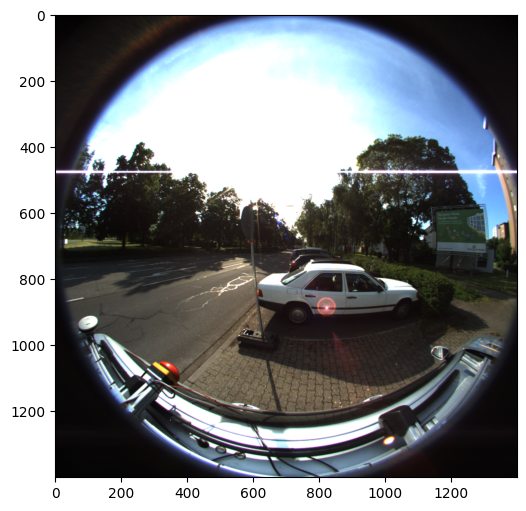

In [2]:
# Left fisheye camera
calib_file_cam02 = 'calib_files/calib_results_02_5.txt'
ocam_02 = OcamCamera(calib_file_cam02, fov=180)
print(ocam_02)

img2 = cv2.imread('/home/angelika/pixelsplat_fisheye/datasets/kitti360/2013_05_28_drive_0000_sync/image_02/data_rgb/0000000000.png')[:,:,::-1]
print('\nImage size: ', img2.shape)
plt.imshow(img2)

In [3]:
save_dir = "/home/angelika/pixelsplat_fisheye/datasets/kitti360/test_rectified"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:


cam = "02"
source_folder = f"/home/angelika/pixelsplat_fisheye/datasets/kitti360/2013_05_28_drive_0000_sync/image_{cam}/data_rgb"
first_frame = 0
last_frame = 249
nb_frames = last_frame - first_frame + 1
filenames = sorted(os.listdir(source_folder))
num_rows = 5  
num_cols = nb_frames // num_rows  

subplot_width = 8  
subplot_height = 6 

fig_width = subplot_width * num_cols
fig_height = subplot_height * num_rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))
available_frames = []
for i, filename in enumerate(filenames):
    if i < nb_frames:
        available_frames.append(i)
        filename_dest = filename
        source_path = os.path.join(source_folder, filename)
        image = cv2.imread(source_path)
        W = 1400
        H = 700
        th = np.pi/H
        p = 2*np.pi/W
        phi = [-np.pi + (i + 0.5)*p for i in range(W)]
        theta = [-np.pi/2 + (i + 0.5)*th for i in range(H)]
        phi_xy, theta_xy  = np.meshgrid(phi, theta, sparse=False, indexing='xy')
        point3D = np.stack([np.sin(phi_xy)*np.cos(theta_xy), np.sin(theta_xy), np.cos(phi_xy)*np.cos(theta_xy)]).reshape(3, -1)
        mapx, mapy = ocam_02.world2cam(point3D)
        mapx = mapx.reshape(H, W)
        mapy = mapy.reshape(H, W)
        out2 = cv2.remap(image, mapx, mapy, cv2.INTER_LINEAR)
        
        
        equiRect2 = out2

        outShape = [700, 700]
        inShape = equiRect2.shape[:2]
        mapper = fisheyeImgConv()

        FOV = 90
        Theta = 0
        Phi = 0
        Hd = outShape[0]
        Wd = outShape[1]
        persp2 = mapper.eqruirect2persp(equiRect2, FOV, Theta, Phi, Hd, Wd)
        #persp2.save(save_dir)
        filename = "{:010d}.png".format(i)
        #filename = f"image_{i}.png"
        save_path = os.path.join(save_dir, filename)
        cv2.imwrite(save_path, persp2)
        
        # Calculate subplot indices
        row_index = i // num_cols
        col_index = i % num_cols

        # Plot the image
        #axes[row_index, col_index].imshow(out2)
        axes[row_index, col_index].imshow(persp2)

        axes[row_index, col_index].axis('off')
        axes[row_index, col_index].set_title(f"Frame {i}")

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Save images for video
for i, theta in enumerate(np.arange(-60, 60)):
    Theta = theta
    Phi = 0
    # persp2 = mapper.eqruirect2persp(equiRect2, FOV, Theta, Phi, Hd, Wd)
    
    # cv2.imwrite(f"fisheye_video/video_0000000000/{i}.png", persp2)
    # # Then: ffmpeg -framerate 20 -i fisheye_proj_02/video_0000001864/%d.png out_1864.mp4
